In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [ ]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [ ]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [ ]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [ ]:
def build_1d_cnn_custom_DO_025_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.25))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [ ]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO_025_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_11 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_29 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.0916 - acc: 0.2195
Epoch 00001: val_loss improved from inf to 2.37649, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_1_conv_checkpoint/001-2.3765.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 4.0916 - acc: 0.2196 - val_loss: 2.3765 - val_acc: 0.2835
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6057 - acc: 0.5325
Epoch 00002: val_loss did not improve from 2.37649
36805/36805 [==============================] - 43s 1ms/sample - loss: 1.6058 - acc: 0.5325 - val_loss: 2.5971 - val_acc: 0.3040
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0652 - acc: 0.6860
Epoch 00003: val_loss did not improve from 2.37649
36805/36805 [==============================] - 43s 1ms/sample - loss: 1.0652 - acc: 0.6860 - val_loss: 2.8670 -

36800/36805 [============================>.] - ETA: 0s - loss: 0.0587 - acc: 0.9920
Epoch 00029: val_loss did not improve from 2.37649
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.0587 - acc: 0.9920 - val_loss: 5.9322 - val_acc: 0.3089
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0767 - acc: 0.9864
Epoch 00030: val_loss did not improve from 2.37649
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.0767 - acc: 0.9864 - val_loss: 8.2275 - val_acc: 0.2530
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0847 - acc: 0.9841
Epoch 00031: val_loss did not improve from 2.37649
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.0847 - acc: 0.9841 - val_loss: 7.0748 - val_acc: 0.2865
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0813 - acc: 0.9843
Epoch 00032: val_loss did not improve from 2.37649
36805/36805 [========================

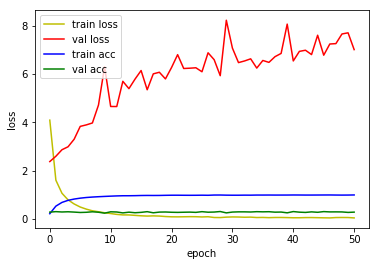

4815/4815 [==============================] - 2s 441us/sample - loss: 2.3987 - acc: 0.2690
Loss: 2.3986952675218274 Accuracy: 0.2689512

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.0756 - acc: 0.2745
Epoch 00001: val_loss improved from inf to 3.68035, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_2_conv_checkpoint/001-3.6803.hdf5
36805/36805 [==============================] - 74s 2ms/sample - loss: 3.0753 - acc: 0.2746 - val_loss: 3.6803 - val_acc: 0.1728
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9406 - acc: 0.4556
Epoch 00002: val_loss improved from 3.68035 to 3.39152, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_2_conv_checkpoint/002-3.3915.hdf5
36805/36805 [==============================] - 72s 2ms/sample - loss: 1.9405 - acc: 0.4556 - val_loss: 3.3915 - val_acc: 0.2516
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1106 - acc: 0.9711
Epoch 00029: val_loss did not improve from 3.04882
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.1106 - acc: 0.9711 - val_loss: 5.4617 - val_acc: 0.3811
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0864 - acc: 0.9782
Epoch 00030: val_loss did not improve from 3.04882
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.0864 - acc: 0.9782 - val_loss: 6.6258 - val_acc: 0.3480
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0816 - acc: 0.9798
Epoch 00031: val_loss did not improve from 3.04882
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.0817 - acc: 0.9798 - val_loss: 5.7342 - val_acc: 0.3848
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0953 - acc: 0.9750
Epoch 00032: val_loss did not improve from 3.04882
36805/36805 [===========

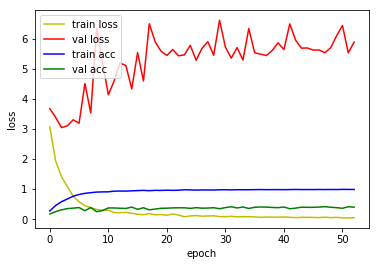

4815/4815 [==============================] - 4s 745us/sample - loss: 3.0891 - acc: 0.2945
Loss: 3.0890887787780286 Accuracy: 0.29449636

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2295 - acc: 0.3582
Epoch 00001: val_loss improved from inf to 2.55584, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_3_conv_checkpoint/001-2.5558.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 2.2294 - acc: 0.3583 - val_loss: 2.5558 - val_acc: 0.2471
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4830 - acc: 0.5539
Epoch 00002: val_loss improved from 2.55584 to 1.77632, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_3_conv_checkpoint/002-1.7763.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 1.4830 - acc: 0.5539 - val_loss: 1.7763 - val_acc: 0.4917
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - l

In [ ]:
for i in range(1, 10):
    model_name = '1D_CNN_custom_DO_025_DO_BN_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO_025_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [ ]:
for i in range(1, 10):
    model_name = '1D_CNN_custom_DO_025_DO_BN_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)